# Лабораторная работа №4. Позиционные игры. Метод обратной индукции

_Цель работы_ — изучить метод обратной индукции и его применение к решению конечных позиционных игр с полной информацией. Изучить свойства решений таких игр.

### Поставновка задачи

Найти решение конечношаговой позиционной игры с полной информацией. Для этого сгенерировать и построить дерево случайной игры согласно варианту, используя метод обратной индукции, найти решение игры и путь (все пути, если он не единственный) к этому решению. Обозначить их на дереве.

Отчёт должен содержать: титульный лист; цель работы; постановку задачи; построенное дерево исходной игры; все найденные методом обратной индукции пути на дереве позиционной игры; решение игры.

### Вариант 19

|Глубина дерева|Количество игроков|Количество стратегий|Диапазон выигрышей|
|---|---|---|---|
|5|3|3, 2, 2|[-10, 10]|

In [5]:
import numpy as np
import graphviz
from colorsys import hsv_to_rgb
from IPython.display import display
from graphviz import Digraph
from colorsys import hsv_to_rgb
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

Зададим класс вершины:

In [6]:
class Node:
    def __init__(self, id=None, parent=None, player=None):
        self.id = id
        self.parent = parent
        self.children = []
        self.strategies = []
        self.player = player
        self.paths = []

    def is_terminal(self):
        return len(self.children) == 0

Игра:

In [7]:
class Game:
    def __init__(self, height, players_count, strategies_count, random_limits):
        self.height = height
        self.players_count = players_count
        self.strategies_count = strategies_count
        self.random_limits = random_limits
        self.tree = None

    def subtree_heights(self, height, count):
        # выбираем величины поддеревьев так, чтобы финальная величина была равна заданной
        return np.append(np.random.randint(0, height, size=count - 1), height)[
            np.random.choice(count, count, replace=False)]

    def create_tree(self):
        ids = {'id': 0}
        root = Node(id=ids['id'], player=0)
        heights = self.subtree_heights(self.height, self.players_count)
        for i in range(self.players_count):
            ids['id'] += 1
            child = Node(id=ids['id'], parent=root)
            self.create_subtree(child, heights[i], i, ids)
            root.children.append(child)
        self.fill_terminals(self.get_terminals(root))
        root.paths = [i for i in range(self.players_count)]
        self.tree = root

    def create_subtree(self, root, height, turn, ids):
        root.player = turn
        if height <= 1:
            return
        heights = self.subtree_heights(height - 1, self.strategies_count[turn])
        for i in range(self.strategies_count[turn]):
            ids['id'] += 1
            child = Node(id=ids['id'], parent=root)
            self.create_subtree(child, heights[i], (turn + 1) % self.players_count, ids)
            root.children.append(child)

    def get_terminals(self, root):  # получение всех конечных вершин
        if root.is_terminal():
            return [root]
        terminals = []
        for i in root.children:
            terminals.extend(self.get_terminals(i))
        return terminals

    def fill_terminals(self, terminals):
        # случайная генерация стратегий игроков для конечных вершин
        for terminal in terminals:
            terminal.strategies = np.array(
                [np.random.randint(self.random_limits[0], self.random_limits[1], self.players_count)])

    def reverse_tree(self):
        root = self.tree
        for child in root.children:
            self.reverse_subtree(child)
            root.strategies = np.append(root.strategies, child.strategies)
        root.strategies = root.strategies.reshape(
            root.strategies.shape[0] // self.players_count,
            self.players_count
        )

    def reverse_subtree(self, root):
        if root.is_terminal():
            return
        all_strategies, root.strategies = [], np.array([])
        for child in root.children:
            self.reverse_subtree(child)
            all_strategies.append(child.strategies)
        # находим максимум среди всех
        maximum = self.random_limits[0]
        for strategies in all_strategies:
            maximum = max(maximum, np.max(strategies[:, root.player]))
        for id, strategies in enumerate(all_strategies):
            if maximum == np.max(strategies[:, root.player]):
                root.strategies = np.append(root.strategies, strategies)
                root.paths.append(id)
        root.strategies = root.strategies.reshape(
            root.strategies.shape[0] // self.players_count,
            self.players_count
        )

    def get_full_paths(self, root):  # получение пути в вершинах
        if root.is_terminal():
            return [[root]]
        paths = []
        for id, child in enumerate(root.children):
            if id in root.paths:
                path = [root]
                child_paths = self.get_full_paths(child)
                for child_path in child_paths:
                    paths.append(path + child_path)
        return paths

    def get_paths_trace(self, paths):  # получение дополнительной информации о путях
        trace = {}
        for id, path in enumerate(paths):
            for i in range(1, len(path)):
                edge = (path[i - 1].id, path[i].id)
                if edge not in trace.keys():
                    trace[edge] = []
                trace[edge].append(id)
        for i in range(len(paths)):
            trace[i] = paths[i][-1].strategies[0]
        return trace

    def generate_dot_strings(self, root, paths_meta=None, digraph=None):
        COLORS = ['red', 'blue', 'green', 'orange', 'pink', 'cyan', 'magenta']
        if digraph is None:
            digraph = Digraph()
        strategies = root.strategies
        if root.parent is None:
            digraph.node(str(root.id), str(strategies))
        else:
            label = ''
            if not root.is_terminal():
                label += f'{root.player + 1}; '
            label += f'{root.id}\\n{strategies}'
            digraph.node(str(root.id), str(label))

        for id, node in enumerate(root.children):
            if paths_meta is not None and (root.id, node.id) in paths_meta.keys():
                for i in paths_meta[(root.id, node.id)]:
                    color, label = COLORS[i], paths_meta[i]
                    digraph.edge(str(root.id), str(node.id), str(label), color=color)
            else:
                digraph.edge(str(root.id), str(node.id))
            self.generate_dot_strings(node, paths_meta, digraph)
        return digraph

    def display_tree(self):
        paths = self.get_full_paths(self.tree)
        meta = self.get_paths_trace(paths)
        digraph = self.generate_dot_strings(self.tree, meta)

        display(digraph)

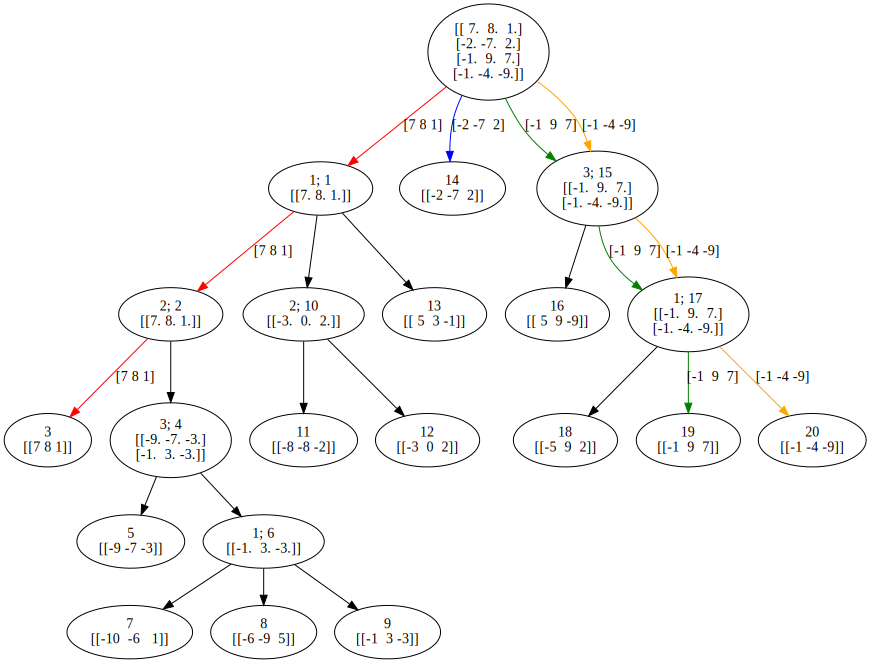

In [8]:
g = Game(height=5, players_count=3, strategies_count=(3, 2, 2), random_limits=(-10, 10))
g.create_tree()
g.reverse_tree()
g.display_tree()